<a href="https://colab.research.google.com/github/Samarth-991/Computer-vision/blob/main/Autoencoder_De_Blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Enhance a Blurred Image using an Autoencoder

“Autoencoders are essentially neural network architectures built with the objective of learning the lower-dimensional feature representations of the input data.”

This network is trained in such a way that the features (z) can be used to reconstruct the original input data (x). If the output (Ẋ) is different from the input (x), the loss penalizes it and helps to reconstruct the input data.

https://www.analyticsvidhya.com/blog/2020/02/what-is-autoencoder-enhance-image-resolution/

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model,Input , regularizers
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing import image

from sklearn.model_selection import train_test_split
import tqdm
import gc
import os
import glob
import warnings
warnings.filterwarnings('ignore')
gc.collect()
seed = np.random.seed(42)
# download dataset
# !wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# !tar -xvzf lfw.tgz

In [2]:
#capture paths to images
face_images = glob.glob('lfw/**/*.jpg')
print(len(face_images))

13233


(250, 250, 3)


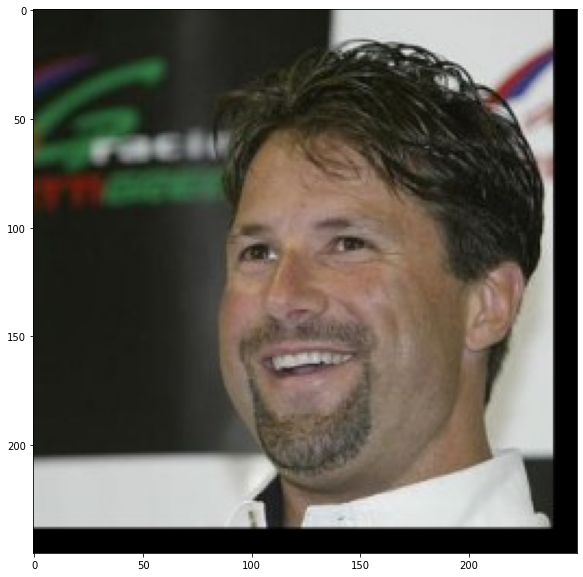

In [3]:
sample_image = face_images[np.random.randint(10,len(face_images))]
plt.figure(figsize=(10,10))
sample_img = cv2.imread(sample_image)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
print(sample_img.shape)

In [4]:
all_imgs = []
IMG_shape= (80,80)
for imgs in face_images:
    img = image.load_img(imgs,target_size=(IMG_shape[0],IMG_shape[1],3))
    img = image.img_to_array(img)# image converted to float 32
    img = img/255.0
    all_imgs.append(img)

all_imgs = np.asarray(all_imgs)
print(all_imgs.shape)

gc.collect()

(13233, 80, 80, 3)


2224

In [5]:
x_train,x_test = train_test_split(all_imgs,random_state=seed,train_size=0.90,test_size=.10)
print(x_train.shape)
print(x_test.shape)

(11909, 80, 80, 3)
(1324, 80, 80, 3)


## Apply transformation
We will apply some modifications in the input image and calculate the loss using the original image. Since it is a resolution enhancement task, we will lower the resolution of the original image and feed it as an input to the model.

In [6]:
# function to reduce image resolution while keeping the image size constant
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [7]:
train_x_px = []
for i in range(x_train.shape[0]):
    px_img = pixalate_image(x_train[i])
    train_x_px.append(px_img)

train_x_px = np.array(train_x_px)
print(train_x_px.shape)

(11909, 80, 80, 3)


In [8]:
val_x_px = []
for i in range(x_test.shape[0]):
    px_img = pixalate_image(x_test[i])
    val_x_px.append(px_img)

val_x_px = np.array(val_x_px)
print(val_x_px.shape)

(1324, 80, 80, 3)


(80, 80, 3)


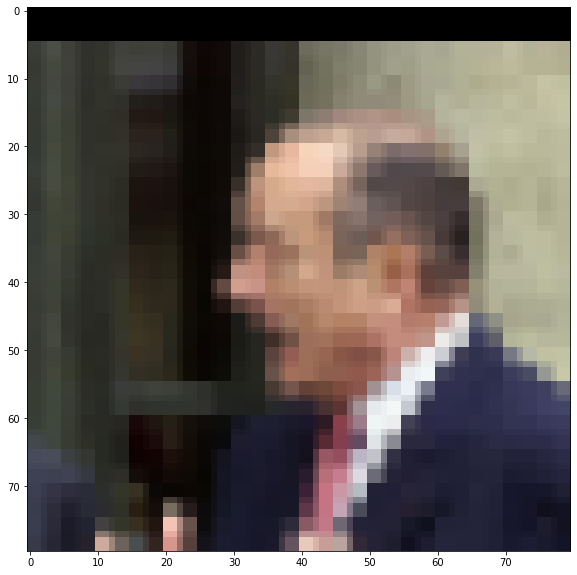

In [9]:
sample_img= train_x_px[np.random.randint(10,len(face_images))]
plt.figure(figsize=(10,10))
plt.imshow(sample_img)
print(sample_img.shape)

In [10]:
#Model building
Input_img = Input(shape=(80,80,3))

# encoding architecture
x1 = Conv2D(256,(3,3),activation='relu',padding='same',
            kernel_regularizer=regularizers.l2())(Input_img)
x2 = Conv2D(128,(3,3),activation='relu',padding='same',
            kernel_regularizer=regularizers.l2())(x1)
x2 = MaxPool2D(2,2)(x2)
encoded = Conv2D(64,(3,3),activation='relu',padding='same')(x2)

# Decoding architectre
x3 = Conv2D(64,(3,3),activation='relu',padding='same')(encoded)
x3 = UpSampling2D((2,2))(x3)
x2 = Conv2D(128,(3,3),activation='relu',padding='same',
            kernel_regularizer=regularizers.l2())(x3)
x1 = Conv2D(256,(3,3),activation='relu',padding='same',
            kernel_regularizer=regularizers.l2())(x2)
decoded  = Conv2D(3,(3,3),padding='same')(x1)


In [11]:
autoencoder = Model(Input_img,decoded)
autoencoder.compile(optimizer='adam',loss='mse')

In [12]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 80, 80, 64)       

In [15]:
checkpoint_path = "training_1/cp.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,monitor='val_loss', verbose=1,
                                      save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')
# a_e = autoencoder.fit(train_x_px, x_train,
#             epochs=10,
#             batch_size=32,
#             shuffle=True,
#             validation_data=(val_x_px, x_test),
#             callbacks=[early_stopper])

In [16]:
# Loads the weights
# !unzip training_1.zip
checkpoint_path = '/content/weights/training_1/cp.ckpt'
autoencoder.load_weights(checkpoint_path)
# Re-evaluate the model
predictions= autoencoder.predict(val_x_px)

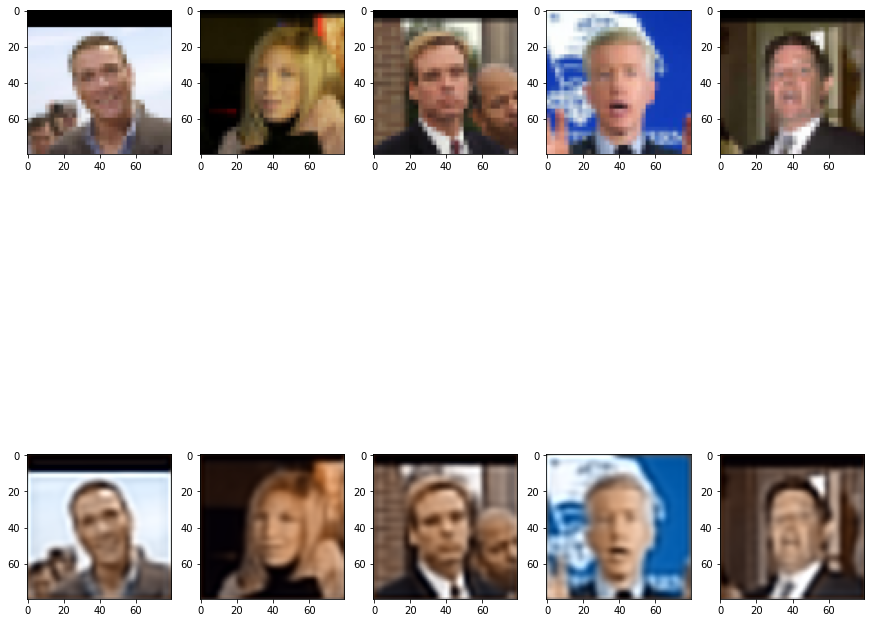

In [17]:
n = 5
plt.figure(figsize=(15,15))
for i in range (n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(val_x_px[i+20])

    ax = plt.subplot(2,n,i+1+n)
    pred_img = np.clip(predictions[i+20],0,1)
    plt.imshow(pred_img)

(1, 80, 80, 3)


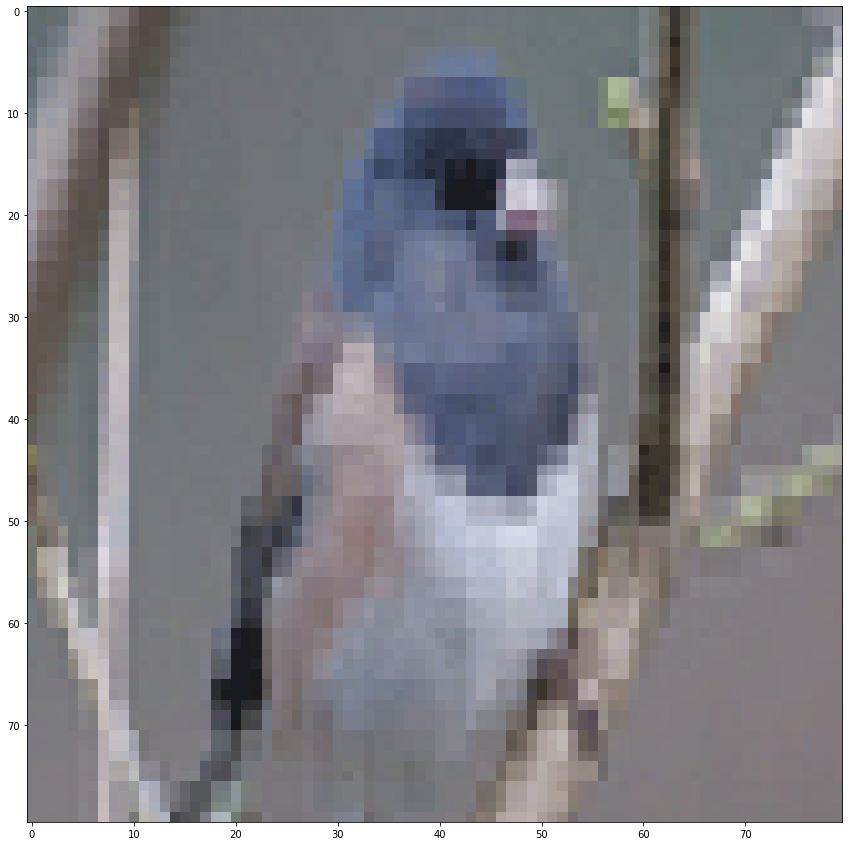

In [36]:
plt.figure(figsize=(15,15))
test_img = '/content/test.jfif'
testimg = image.load_img(test_img,target_size=(IMG_shape[0],IMG_shape[1],3))
plt.imshow(testimg)
# Pre-process image
testimg = image.img_to_array(testimg)# image converted to float 32
testimg = testimg/255.0
testimg = np.expand_dims(testimg,axis=0)
print(testimg.shape)


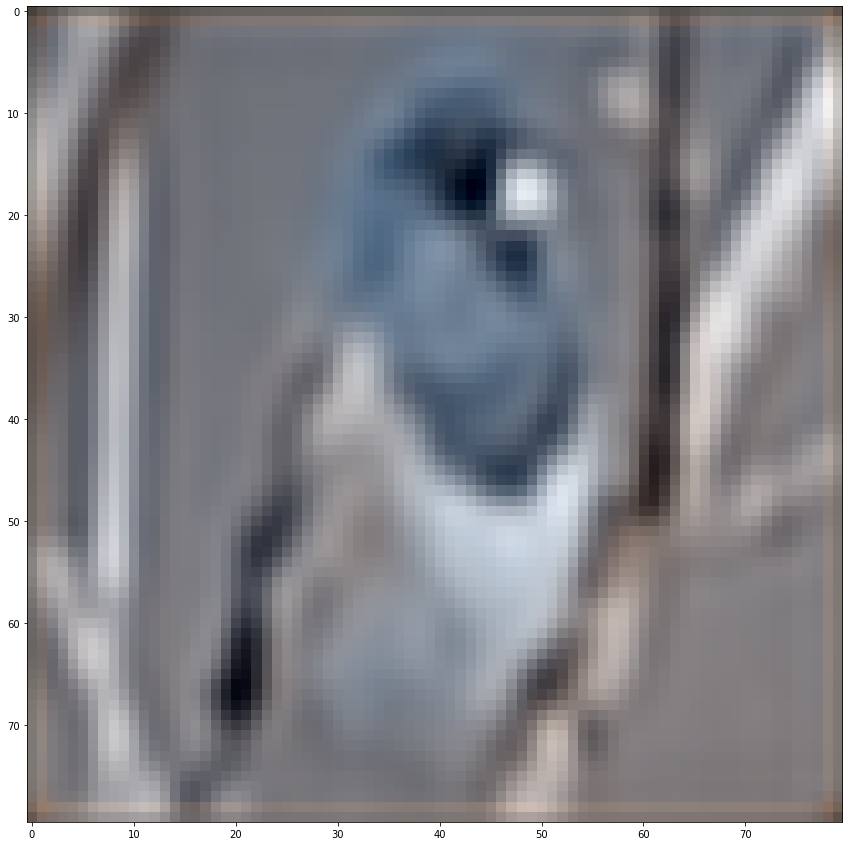

In [33]:
plt.figure(figsize=(15,15))
sharp_img = autoencoder.predict(testimg)
pred_img = np.reshape(sharp_img,(IMG_shape[0],IMG_shape[1],3))
#pred_img
plt.imshow(np.clip(pred_img,0,1))